In [1]:
#@title 1. Setup: Install dependencies (run once)

!pip install -q pandas numpy scikit-learn matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from io import StringIO
from typing import Optional, Dict, List

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    PowerTransformer,
    FunctionTransformer,
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report,
)
from sklearn.inspection import partial_dependence

from google.colab import files

%matplotlib inline
plt.rcParams["figure.dpi"] = 90


In [2]:
#@title 2. Helper functions (data loading, cleaning, preprocessing)

def load_titanic_demo() -> pd.DataFrame:
    """Load Titanic demo dataset from GitHub."""
    url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
    df = pd.read_csv(url)
    return df


def expand_datetime_features(df: pd.DataFrame) -> pd.DataFrame:
    """Detect datetime-like columns and expand into year/month/day."""
    df = df.copy()
    for col in df.columns:
        s = df[col]
        dt = None
        if np.issubdtype(s.dtype, np.datetime64):
            dt = s
        elif s.dtype == "object":
            try:
                dt_candidate = pd.to_datetime(s, errors="raise")
                if np.issubdtype(dt_candidate.dtype, np.datetime64):
                    dt = dt_candidate
            except Exception:
                dt = None
        if dt is not None:
            df[f"{col}_year"] = dt.dt.year
            df[f"{col}_month"] = dt.dt.month
            df[f"{col}_day"] = dt.dt.day
            df = df.drop(columns=[col])
    return df


def remove_outliers(df: pd.DataFrame, numeric_cols: List[str], method: str):
    """Remove outliers from numeric columns using IQR or IsolationForest."""
    if method == "None" or not numeric_cols:
        return df, 0

    df = df.copy()
    initial_rows = len(df)

    if method == "IQR":
        mask = pd.Series(True, index=df.index)
        for col in numeric_cols:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            mask &= df[col].between(lower, upper) | df[col].isna()
        df = df[mask]

    elif method == "IsolationForest":
        numeric_df = df[numeric_cols].dropna()
        if len(numeric_df) > 0:
            iso = IsolationForest(random_state=42, contamination="auto")
            iso.fit(numeric_df)
            preds = iso.predict(numeric_df)
            keep_idx = numeric_df.index[preds == 1]
            df = df.loc[keep_idx]

    removed = initial_rows - len(df)
    return df, removed


def build_preprocessor(
    X: pd.DataFrame,
    imputation_strategy: str,
    skew_strategy: str,
    cat_encoding: str,
    variance_threshold: Optional[float],
    rfe_n_features: Optional[int],
):
    """Build preprocessing + feature-selection + RandomForest pipeline."""
    numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    # Numeric imputers
    if imputation_strategy == "Mean":
        num_imputer = SimpleImputer(strategy="mean")
    elif imputation_strategy == "Median":
        num_imputer = SimpleImputer(strategy="median")
    elif imputation_strategy == "KNN":
        num_imputer = KNNImputer(n_neighbors=5)
    else:
        num_imputer = IterativeImputer(random_state=42)

    cat_imputer = SimpleImputer(strategy="most_frequent")

    # Skew correction
    skew_step = None
    if skew_strategy == "Log1p":
        skew_step = ("skew", FunctionTransformer(lambda x: np.log1p(np.clip(x, 0, None))))
    elif skew_strategy == "Yeo-Johnson":
        skew_step = ("skew", PowerTransformer(method="yeo-johnson"))

    # Categorical encoding
    if cat_encoding == "One-Hot":
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    else:
        encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

    # Numeric pipeline
    num_steps = [("imputer", num_imputer)]
    if skew_step:
        num_steps.append(skew_step)
    num_steps.append(("scaler", StandardScaler()))
    num_tf = Pipeline(num_steps)

    # Categorical pipeline
    cat_tf = Pipeline([
        ("imputer", cat_imputer),
        ("encoder", encoder),
    ])

    pre = ColumnTransformer([
        ("num", num_tf, numeric_cols),
        ("cat", cat_tf, categorical_cols),
    ])

    steps = [("pre", pre)]

    if variance_threshold and variance_threshold > 0:
        steps.append(("var_sel", VarianceThreshold(threshold=variance_threshold)))

    if rfe_n_features and rfe_n_features > 0:
        steps.append((
            "rfe",
            RFE(
                RandomForestClassifier(
                    n_estimators=150,
                    random_state=42,
                    n_jobs=-1
                ),
                n_features_to_select=rfe_n_features
            )
        ))

    steps.append(("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )))

    pipe = Pipeline(steps)
    return pipe, numeric_cols, categorical_cols


def get_feature_names_after_selection(pipe: Pipeline, numeric_cols: List[str], cat_cols: List[str]) -> List[str]:
    """Rebuild feature names after ColumnTransformer + VarianceThreshold + RFE."""
    pre: ColumnTransformer = pipe.named_steps["pre"]

    feature_names = []
    feature_names.extend(numeric_cols)

    if cat_cols:
        encoder = pre.named_transformers_["cat"].named_steps["encoder"]
        if isinstance(encoder, OneHotEncoder):
            feature_names.extend(encoder.get_feature_names_out(cat_cols).tolist())
        else:
            feature_names.extend(cat_cols)

    if "var_sel" in pipe.named_steps:
        mask = pipe.named_steps["var_sel"].get_support()
        feature_names = [n for n, keep in zip(feature_names, mask) if keep]

    if "rfe" in pipe.named_steps:
        mask = pipe.named_steps["rfe"].get_support()
        feature_names = [n for n, keep in zip(feature_names, mask) if keep]

    return feature_names


In [3]:
#@title 3. Configuration: dataset & pipeline choices

DATA_SOURCE = "titanic"  #@param ["titanic", "upload"]

# Data cleaning options
REMOVE_DUPLICATES = True  #@param {type:"boolean"}

IMPUTATION_STRATEGY = "KNN"  #@param ["Mean", "Median", "KNN", "Iterative"]
OUTLIER_METHOD = "IsolationForest"  #@param ["None", "IQR", "IsolationForest"]
SKEW_STRATEGY = "Log1p"  #@param ["None", "Log1p", "Yeo-Johnson"]
CAT_ENCODING = "One-Hot"  #@param ["One-Hot", "Ordinal"]

VARIANCE_THRESHOLD = 0.17  #@param {type:"number"}
RFE_N_FEATURES = 32  #@param {type:"integer"}

TEST_SIZE = 0.25  #@param {type:"number"}

print("Configuration set.")


Configuration set.


In [4]:
#@title 4. Load dataset

if DATA_SOURCE == "titanic":
    df_raw = load_titanic_demo()
    print("Loaded Titanic demo dataset.")
else:
    print("Please upload a CSV file...")
    uploaded = files.upload()
    fname = list(uploaded.keys())[0]
    df_raw = pd.read_csv(fname)
    print(f"Loaded {fname}")

# Drop high-cardinality columns like in the Streamlit app
df_raw = df_raw.drop(columns=["Name", "Ticket", "Cabin"], errors="ignore")

print(f"\nRaw shape: {df_raw.shape}")
display(df_raw.head())


Loaded Titanic demo dataset.

Raw shape: (891, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [5]:
#@title 5. Data cleaning pipeline

df = df_raw.copy()

if REMOVE_DUPLICATES:
    before = len(df)
    df = df.drop_duplicates()
    print(f"Removed {before - len(df)} duplicate rows.")

# Choose target (default: Survived if present)
if "Survived" in df.columns:
    target_col = "Survived"
else:
    target_col = df.columns[-1]

df = df.dropna(subset=[target_col]).copy()

# Datetime feature expansion
df = expand_datetime_features(df)

# Outliers
numeric_cols_all = df.drop(columns=[target_col]).select_dtypes(include=["number"]).columns.tolist()
df, removed_outliers = remove_outliers(df, numeric_cols_all, OUTLIER_METHOD)
print(f"Outlier removal ({OUTLIER_METHOD}) removed {removed_outliers} rows.")

print(f"\nAfter cleaning: {df.shape}")
display(df.head())


Removed 0 duplicate rows.


/tmp/ipython-input-1699346529.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_candidate = pd.to_datetime(s, errors="raise")
/tmp/ipython-input-1699346529.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_candidate = pd.to_datetime(s, errors="raise")


Outlier removal (IsolationForest) removed 342 rows.

After cleaning: (549, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
2,3,1,3,female,26.0,0,0,7.9250,S
4,5,0,3,male,35.0,0,0,8.0500,S
12,13,0,3,male,20.0,0,0,8.0500,S
14,15,0,3,female,14.0,0,0,7.8542,S


In [6]:
#@title 6. Train model & evaluate

y = df[target_col]
X = df.drop(columns=[target_col])

pipe, num_cols, cat_cols = build_preprocessor(
    X,
    imputation_strategy=IMPUTATION_STRATEGY,
    skew_strategy=SKEW_STRATEGY,
    cat_encoding=CAT_ENCODING,
    variance_threshold=VARIANCE_THRESHOLD if VARIANCE_THRESHOLD > 0 else None,
    rfe_n_features=RFE_N_FEATURES if RFE_N_FEATURES > 0 else None,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision_weighted": precision_score(y_test, y_pred, average="weighted", zero_division=0),
    "recall_weighted": recall_score(y_test, y_pred, average="weighted", zero_division=0),
    "f1_weighted": f1_score(y_test, y_pred, average="weighted", zero_division=0),
}

print("=== Evaluation metrics ===")
for k, v in metrics.items():
    print(f"{k:20s}: {v:.4f}")

print("\n=== Classification report ===")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=32 > n_features=8. There will be no feature selection and all features will be kept.
  warnings.warn(


=== Evaluation metrics ===
accuracy            : 0.8623
precision_weighted  : 0.8622
recall_weighted     : 0.8623
f1_weighted         : 0.8598

=== Classification report ===
              precision    recall  f1-score   support

           0       0.86      0.93      0.90        88
           1       0.86      0.74      0.80        50

    accuracy                           0.86       138
   macro avg       0.86      0.84      0.85       138
weighted avg       0.86      0.86      0.86       138



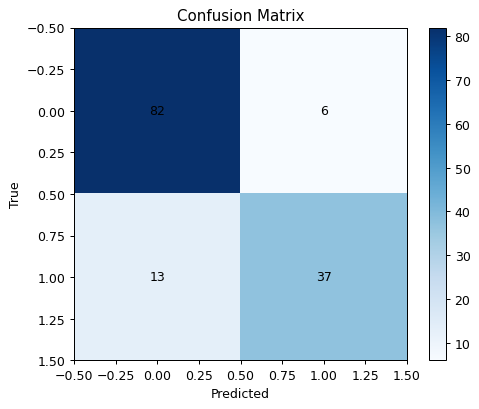

In [7]:
#@title 7. Confusion matrix

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
fig.colorbar(im, ax=ax)
plt.show()


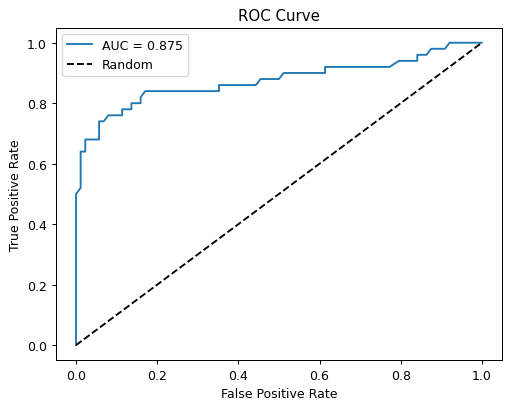

In [8]:
#@title 8. ROC curve (binary only)

if hasattr(pipe, "predict_proba") and len(np.unique(y)) == 2:
    y_proba = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = roc_auc_score(y_test, y_proba)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    ax.plot([0,1],[0,1],"k--", label="Random")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    ax.set_title("ROC Curve")
    plt.show()
else:
    print("ROC curve only available for binary classification.")


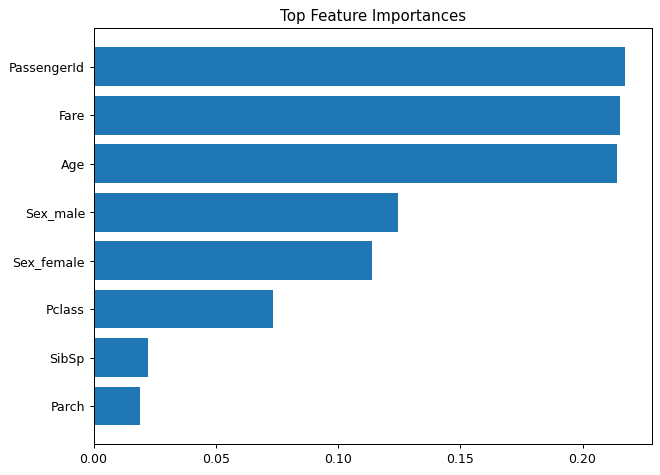

In [9]:
#@title 9. Feature importance (RandomForest)

feature_names = get_feature_names_after_selection(pipe, num_cols, cat_cols)
importances = pipe["model"].feature_importances_

if len(feature_names) != len(importances):
    feature_names = [f"feature_{i}" for i in range(len(importances))]

fi_df = pd.DataFrame({"feature": feature_names, "importance": importances})
fi_df = fi_df.sort_values("importance", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(fi_df["feature"], fi_df["importance"])
ax.invert_yaxis()
ax.set_title("Top Feature Importances")
plt.show()


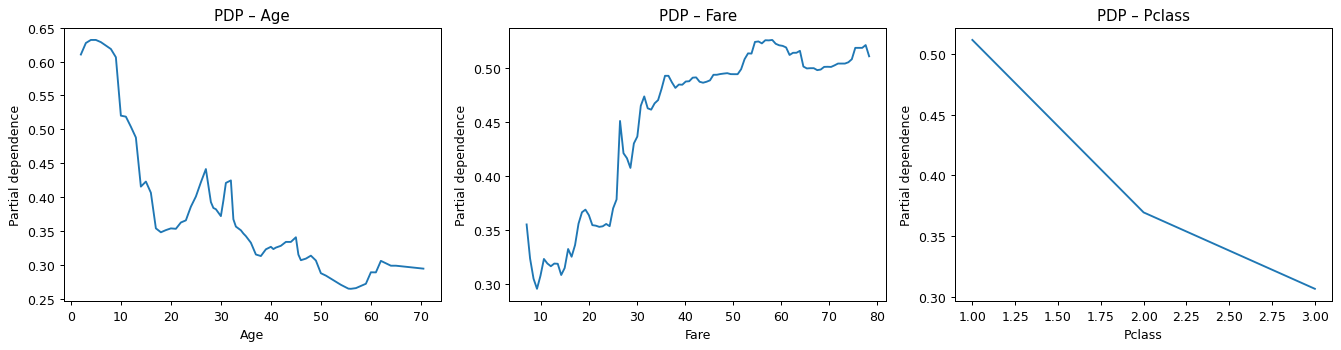

In [10]:
#@title 10. Partial Dependence Plots (PDP)

numeric_cols_all = X.select_dtypes(include=["number"]).columns.tolist()
candidate_pdp_cols = [c for c in ["Age", "Fare", "Pclass"] if c in numeric_cols_all]
if not candidate_pdp_cols:
    candidate_pdp_cols = numeric_cols_all[:2]

# Convert int to float for PDP safety
X_pdp = X_train.copy()
for c in candidate_pdp_cols:
    if np.issubdtype(X_pdp[c].dtype, np.integer):
        X_pdp[c] = X_pdp[c].astype(float)

n_features = len(candidate_pdp_cols)
fig, axes = plt.subplots(1, n_features, figsize=(5*n_features, 4))

if n_features == 1:
    axes = [axes]

for ax, feat in zip(axes, candidate_pdp_cols):
    pdp_res = partial_dependence(pipe, X=X_pdp, features=[feat])
    grid = pdp_res["grid_values"][0]
    avg = pdp_res["average"][0]
    ax.plot(grid, avg)
    ax.set_title(f"PDP – {feat}")
    ax.set_xlabel(feat)
    ax.set_ylabel("Partial dependence")

plt.tight_layout()
plt.show()
